In [1]:
%matplotlib notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## 5. Algorithm
1. 很多算法为了降低优势函数的估计误差都会学习状态值函数$v(s)$，因此可以使用actor和critic共享的架构，例如:
    - [High-Dimensional Continuous Control Using Generalized Advantage Estimation
](https://arxiv.org/abs/1506.02438)
    - [Asynchronous Methods for Deep Reinforcement Learning](https://arxiv.org/abs/1602.01783)
2. 为了保证算法探索性能可以增加entropy bonus

$$L_t^{CLIP + VF + S}(\theta) = \mathbb{\hat{E}}_t[L_t^{CLIP}(\theta)- c_1L_t^{VF}(\theta) + c_2S[\pi_{\theta}](s_t)]$$
其中$L_t^{VF}(\theta) = (V_{\theta}(s_t) - V_t^{target})^2$

3. 有些PG算法runs the policy for $T$ timesteps，使用以下优势函数：
$$\hat{A}_t = r_t + \gamma r_{t+1} + ... + \gamma ^{T-t+1}r_{T-1} + \gamma ^{T-t}V(s_T) - V(s_t)$$

In [22]:
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import datetime
import random

In [23]:
# from tensorboard import notebook

# # 初始化 SummaryWriter，日志将保存在'runs'目录下
# writer = SummaryWriter(f"./logs/{datetime.datetime.now()}")

# # 启动 TensorBoard 并指定日志目录
# notebook.start("--logdir runs")

# # 可选：创建一个链接直接跳转到 TensorBoard 界面
# # notebook.display(height=400)

In [24]:
# %matplotlib qt5

In [87]:
class ActorCritic(nn.Module):
    def __init__(self, n_state, n_action, hidden_size = 64):
        super(ActorCritic, self).__init__()
        
        self.fc1 = torch.nn.Linear(n_state, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc_mean = torch.nn.Linear(hidden_size, n_action)
        self.fc_std = torch.nn.Linear(hidden_size, n_action)
        self.fc_critic = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):
        x = self.fc1(state)
        x = self.fc2(F.relu(x))
        mu = torch.tanh(self.fc_mean(F.relu(x))) * 1.0
        std = F.softplus(self.fc_std(F.relu(x))) #+ 0e-3
        # std = torch.ones_like(mu) * 1.0  # 固定标准差，增强探索

        critic = self.fc_critic(F.relu(x))
        return mu, std, critic


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class PPOContinuous(nn.Module):

    def __init__(self, n_state, n_action, n_hidden = 64, actor_lr=1e-4, critic_lr=1e-4, lmbda=0.1, epochs=10, eps=0.01, gamma=0.99, device="cpu"):
        super(PPOContinuous, self).__init__()
        print(f"{n_state=}, {n_action=}, {n_hidden=}")

        self.actor_critc = ActorCritic(n_state, n_action, hidden_size=n_hidden)
        self.opt = torch.optim.Adam(self.actor_critc.parameters(), lr = actor_lr)
        
        self.lmbda = lmbda
        self.gamma = gamma
        self.eps = eps
        self.epochs = epochs
        self.device = device

    def take_action(self, state, eval = False):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std, _ = self.actor_critc(state)

        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()

        if not eval:
            r = random.uniform(-1, 1) * 0.0
        else:
            r = 0.

        # return [np.clip(action.item() + r, -1, 1)]
        return [action.item()]
        

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device) 

        _, _, next_state_critic = self.actor_critc(next_states)
        td_target = rewards + self.gamma * next_state_critic * (1 - dones)

        mu, std, state_critic = self.actor_critc(states)
        td_delta = td_target - state_critic
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta)

        action_dist = torch.distributions.Normal(mu.detach(), std.detach())
        old_log_probs = action_dist.log_prob(actions)

        for _ in range(self.epochs):
            mu, std, critic = self.actor_critc(states)

            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            action_dist_entropy = action_dists.entropy().sum(dim=-1).mean()

            # print(action_dist_entropy)

            ratio = torch.exp(log_probs - old_log_probs)
            # ratio = torch.clamp(ratio, min=-1e6, max=1e6)
            l1 = ratio * advantage
            l2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            l3 = - torch.min(l1, l2)

            actor_loss = torch.mean(l3)
            critic_loss = torch.mean(F.mse_loss(critic, td_target.detach()))

            loss = actor_loss + 1 * critic_loss - 0.1 * action_dist_entropy

            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        print(f"====actor_loss: {actor_loss.detach().item()}, critic_loss: {critic_loss.detach().item()}, entropy:{action_dist_entropy.detach().item()}")
        

In [88]:
actor_lr = 1e-4
critic_lr = 1e-3
num_episodes = 2000
hidden = 128

gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.4

device = "cpu"
env_name = "MountainCarContinuous-v0"
# env_name = "Pendulum-v1"


env = gym.make(env_name)
torch.manual_seed(0)
print(f"state space:" , env.observation_space.sample())
print(f"action space: {env.action_space}")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = PPOContinuous(n_state=state_dim, n_action=action_dim, n_hidden=hidden,actor_lr=actor_lr, critic_lr=critic_lr)

state space: [-0.3743548  -0.03135797]
action space: Box(-1.0, 1.0, (1,), float32)
n_state=2, n_action=1, n_hidden=128


In [89]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    episode_return = 0

    for epoch in range(num_episodes//100):
    
        for i in tqdm(range(100), position=0, desc=f"###{epoch} : {episode_return} "):
            episode_return = 0
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            state, _ = env.reset()
            done , truncated = False, False
            while not done and not truncated:
                action = agent.take_action(state)
                next_state, reward, done, truncated, info = env.step(action)
    
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)


    return return_list
        
return_list = train_on_policy_agent(env, agent, num_episodes)

###0 : 0 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0497383289039135, critic_loss: 0.003780993865802884, entropy:1.0301905870437622
====actor_loss: 0.054943475872278214, critic_loss: 0.004578634165227413, entropy:1.045731782913208
====actor_loss: 0.05109555274248123, critic_loss: 0.004172702319920063, entropy:1.0585252046585083
====actor_loss: 0.05482429265975952, critic_loss: 0.005740830674767494, entropy:1.0626163482666016
====actor_loss: 0.04906271770596504, critic_loss: 0.0048043495044112206, entropy:1.0748399496078491
====actor_loss: 0.05540694668889046, critic_loss: 0.005781383719295263, entropy:1.0819722414016724
====actor_loss: 0.05074197053909302, critic_loss: 0.0047963871620595455, entropy:1.090639352798462
====actor_loss: 0.05440020188689232, critic_loss: 0.00561967957764864, entropy:1.0958361625671387
====actor_loss: 0.05682675540447235, critic_loss: 0.006324085872620344, entropy:1.0987403392791748
====actor_loss: 0.05210006609559059, critic_loss: 0.0062364740297198296, entropy:1.0980418920516968
====actor_

###1 : -67.54717873436395 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.01963403820991516, critic_loss: 0.009377389214932919, entropy:1.187132716178894
====actor_loss: 0.01716115139424801, critic_loss: 0.00739549845457077, entropy:1.1905025243759155
====actor_loss: 0.01930571347475052, critic_loss: 0.008962000720202923, entropy:1.1892852783203125
====actor_loss: 0.014490033499896526, critic_loss: 0.007405139971524477, entropy:1.18665611743927
====actor_loss: 0.021070264279842377, critic_loss: 0.00938770268112421, entropy:1.185744047164917
====actor_loss: -0.15371303260326385, critic_loss: 15.70334529876709, entropy:1.1935243606567383
====actor_loss: 0.017006196081638336, critic_loss: 0.013856758363544941, entropy:1.1949394941329956
====actor_loss: 0.01751498132944107, critic_loss: 0.008266612887382507, entropy:1.1901761293411255
====actor_loss: 0.015804873779416084, critic_loss: 0.007800652179867029, entropy:1.1926969289779663
====actor_loss: 0.022178974002599716, critic_loss: 0.009602207690477371, entropy:1.1937384605407715
====actor_los

###2 : -61.50823141343938 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0019642224069684744, critic_loss: 0.006603287532925606, entropy:1.14948570728302
====actor_loss: 0.0019456343725323677, critic_loss: 0.007402797229588032, entropy:1.147337794303894
====actor_loss: -0.0012565494980663061, critic_loss: 0.006552698090672493, entropy:1.148403525352478
====actor_loss: 0.0022128757555037737, critic_loss: 0.007260482758283615, entropy:1.146183967590332
====actor_loss: 6.619755004066974e-05, critic_loss: 0.006092332769185305, entropy:1.1521022319793701
====actor_loss: 0.006532123312354088, critic_loss: 0.009116806089878082, entropy:1.1518491506576538
====actor_loss: 0.0062066614627838135, critic_loss: 0.009331673383712769, entropy:1.151908278465271
====actor_loss: 0.002509178128093481, critic_loss: 0.006803741678595543, entropy:1.1546710729599
====actor_loss: 0.0044257002882659435, critic_loss: 0.008363825269043446, entropy:1.1524100303649902
====actor_loss: -0.0009419507696293294, critic_loss: 0.006125750485807657, entropy:1.1597551107406616

###3 : -68.72705194231126 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.004075496923178434, critic_loss: 0.008216054178774357, entropy:1.1960395574569702
====actor_loss: 0.002446400932967663, critic_loss: 0.006567494943737984, entropy:1.2056137323379517
====actor_loss: 0.004061911720782518, critic_loss: 0.009111982770264149, entropy:1.2045077085494995
====actor_loss: 0.0038884514942765236, critic_loss: 0.008292043581604958, entropy:1.2028578519821167
====actor_loss: 0.00536617124453187, critic_loss: 0.009138972498476505, entropy:1.2019550800323486
====actor_loss: 0.003992971032857895, critic_loss: 0.008625819347798824, entropy:1.200979232788086
====actor_loss: 0.0036635666619986296, critic_loss: 0.007632898166775703, entropy:1.199917197227478
====actor_loss: 0.002401662291958928, critic_loss: 0.0081821009516716, entropy:1.198251485824585
====actor_loss: -0.0004018714535050094, critic_loss: 0.007058722898364067, entropy:1.2047137022018433
====actor_loss: 0.0018824542639777064, critic_loss: 0.00771225756034255, entropy:1.2053502798080444
==

###4 : -61.92012017653239 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.17893821001052856, critic_loss: 16.245201110839844, entropy:1.1957255601882935
====actor_loss: 0.004508300684392452, critic_loss: 0.01249729935079813, entropy:1.2026859521865845
====actor_loss: 0.0032807732932269573, critic_loss: 0.008067409507930279, entropy:1.2046964168548584
====actor_loss: -0.14166581630706787, critic_loss: 12.98877239227295, entropy:1.2100293636322021
====actor_loss: 0.002147666411474347, critic_loss: 0.00988558679819107, entropy:1.2091307640075684
====actor_loss: 0.004432951100170612, critic_loss: 0.008979124017059803, entropy:1.2104257345199585
====actor_loss: 0.007254770491272211, critic_loss: 0.009379240684211254, entropy:1.2103315591812134
====actor_loss: 0.007035704329609871, critic_loss: 0.009668939746916294, entropy:1.20835542678833
====actor_loss: 0.006459529045969248, critic_loss: 0.00831407681107521, entropy:1.2071993350982666
====actor_loss: 0.0037566530518233776, critic_loss: 0.007964655756950378, entropy:1.2071629762649536
====acto

###5 : -63.71433309602015 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0081570353358984, critic_loss: 0.01104442123323679, entropy:1.1878348588943481
====actor_loss: 0.008273765444755554, critic_loss: 0.015486383810639381, entropy:1.181410551071167
====actor_loss: 0.008259096182882786, critic_loss: 0.008877567946910858, entropy:1.1826484203338623
====actor_loss: 0.0101769482716918, critic_loss: 0.012261206284165382, entropy:1.1793416738510132
====actor_loss: 0.0006557176820933819, critic_loss: 0.00761489337310195, entropy:1.185500979423523
====actor_loss: 0.010363219305872917, critic_loss: 0.0095449797809124, entropy:1.183173418045044
====actor_loss: 0.005313217639923096, critic_loss: 0.007649041712284088, entropy:1.1838116645812988
====actor_loss: 0.008195838890969753, critic_loss: 0.013244043104350567, entropy:1.1757534742355347
====actor_loss: 0.009579685516655445, critic_loss: 0.009126285091042519, entropy:1.178391933441162
====actor_loss: 0.0037623329553753138, critic_loss: 0.007330272346735001, entropy:1.178252100944519
====actor_l

###6 : -64.93831163279513 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.0022585929837077856, critic_loss: 0.011292638257145882, entropy:1.1745412349700928
====actor_loss: -0.0041601210832595825, critic_loss: 0.0059527806006371975, entropy:1.1808063983917236
====actor_loss: 0.0011887330329045653, critic_loss: 0.007666974328458309, entropy:1.1798241138458252
====actor_loss: -0.0014128059847280383, critic_loss: 0.007157956250011921, entropy:1.1830716133117676
====actor_loss: 0.010562344454228878, critic_loss: 0.009566836059093475, entropy:1.1806135177612305
====actor_loss: 0.004818418528884649, critic_loss: 0.014221178367733955, entropy:1.1744109392166138
====actor_loss: 0.0013687144964933395, critic_loss: 0.008111606352031231, entropy:1.1802291870117188
====actor_loss: 0.0004865077789872885, critic_loss: 0.010128999128937721, entropy:1.1804076433181763
====actor_loss: 0.0035862717777490616, critic_loss: 0.009055604226887226, entropy:1.1800047159194946
====actor_loss: 0.00379313831217587, critic_loss: 0.00827860739082098, entropy:1.178484439

###7 : -62.98714823808562 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.008547660894691944, critic_loss: 0.02382621355354786, entropy:1.1796865463256836
====actor_loss: 0.005384851712733507, critic_loss: 0.014137432910501957, entropy:1.1818840503692627
====actor_loss: 0.010439633391797543, critic_loss: 0.015750745311379433, entropy:1.181223750114441
====actor_loss: 0.0013160454109311104, critic_loss: 0.009641021490097046, entropy:1.1810756921768188
====actor_loss: 0.0006068017682991922, critic_loss: 0.008537796325981617, entropy:1.1822853088378906
====actor_loss: 0.00199629133567214, critic_loss: 0.007247823756188154, entropy:1.1806201934814453
====actor_loss: -0.00013188121374696493, critic_loss: 0.009458339773118496, entropy:1.178039312362671
====actor_loss: -0.0021218890324234962, critic_loss: 0.010630897246301174, entropy:1.17872953414917
====actor_loss: -0.0005230215028859675, critic_loss: 0.008230995386838913, entropy:1.1799395084381104
====actor_loss: 0.004994357470422983, critic_loss: 0.010148696601390839, entropy:1.18003535270690

###8 : -64.51836063703347 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.003279442200437188, critic_loss: 0.00983835756778717, entropy:1.2011091709136963
====actor_loss: -0.00041454663733020425, critic_loss: 0.010904495604336262, entropy:1.2006256580352783
====actor_loss: -0.14158359169960022, critic_loss: 11.642480850219727, entropy:1.1934986114501953
====actor_loss: 0.004455171525478363, critic_loss: 0.01194013748317957, entropy:1.1966251134872437
====actor_loss: 0.003681377274915576, critic_loss: 0.0128535907715559, entropy:1.1937083005905151
====actor_loss: 0.0009463760652579367, critic_loss: 0.023290351033210754, entropy:1.177274227142334
====actor_loss: 0.003379091853275895, critic_loss: 0.008255180902779102, entropy:1.1912082433700562
====actor_loss: 0.01229881215840578, critic_loss: 0.012831969186663628, entropy:1.1895674467086792
====actor_loss: 0.001476965844631195, critic_loss: 0.009657513350248337, entropy:1.1879557371139526
====actor_loss: -0.0016745656030252576, critic_loss: 0.009234228171408176, entropy:1.1869560480117798
==

###9 : -65.8863170379877 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.008135202340781689, critic_loss: 0.011263573542237282, entropy:1.2044553756713867
====actor_loss: 0.0005064681172370911, critic_loss: 0.009440997615456581, entropy:1.203069806098938
====actor_loss: 0.0058982763439416885, critic_loss: 0.012562736868858337, entropy:1.195940375328064
====actor_loss: 0.0004502582596614957, critic_loss: 0.012201372534036636, entropy:1.195439338684082
====actor_loss: 0.003707285737618804, critic_loss: 0.010427402332425117, entropy:1.1969188451766968
====actor_loss: -0.0031686078291386366, critic_loss: 0.008153336122632027, entropy:1.1963070631027222
====actor_loss: -6.083235712139867e-05, critic_loss: 0.008923720568418503, entropy:1.1953870058059692
====actor_loss: -0.004012614022940397, critic_loss: 0.008113357238471508, entropy:1.196242332458496
====actor_loss: 0.003428027732297778, critic_loss: 0.008798270486295223, entropy:1.1934587955474854
====actor_loss: 0.001092161051928997, critic_loss: 0.007930348627269268, entropy:1.1929593086242

###10 : -61.398743799945976 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.00303229340352118, critic_loss: 0.0073163448832929134, entropy:1.1899158954620361
====actor_loss: -0.007537765894085169, critic_loss: 0.008749878033995628, entropy:1.1875289678573608
====actor_loss: 0.002029602648690343, critic_loss: 0.007659261114895344, entropy:1.190295696258545
====actor_loss: -0.0002882262342609465, critic_loss: 0.009488210082054138, entropy:1.1888291835784912
====actor_loss: -0.003830462694168091, critic_loss: 0.007335813716053963, entropy:1.1878321170806885
====actor_loss: -0.0009931245585903525, critic_loss: 0.007200855761766434, entropy:1.1853218078613281
====actor_loss: -0.0038185997400432825, critic_loss: 0.006800529081374407, entropy:1.1840934753417969
====actor_loss: -0.005188785493373871, critic_loss: 0.006964949890971184, entropy:1.1856886148452759
====actor_loss: 0.0015483757015317678, critic_loss: 0.010769817046821117, entropy:1.1855965852737427
====actor_loss: -0.0010660376865416765, critic_loss: 0.007458897773176432, entropy:1.18488

###11 : -63.67308976148132 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.007012595422565937, critic_loss: 0.0073542483150959015, entropy:1.2045607566833496
====actor_loss: 0.0014881710521876812, critic_loss: 0.009024521335959435, entropy:1.2024130821228027
====actor_loss: -0.0038125496357679367, critic_loss: 0.007108293008059263, entropy:1.200858473777771
====actor_loss: -0.0024424910079687834, critic_loss: 0.0092476112768054, entropy:1.199491024017334
====actor_loss: -0.002059847116470337, critic_loss: 0.011107353493571281, entropy:1.2006813287734985
====actor_loss: 0.004000475630164146, critic_loss: 0.011594369076192379, entropy:1.2026817798614502
====actor_loss: 0.0011869616573676467, critic_loss: 0.012897897511720657, entropy:1.1972893476486206
====actor_loss: -0.0007900145137682557, critic_loss: 0.009242200292646885, entropy:1.1947709321975708
====actor_loss: 0.0002602117892820388, critic_loss: 0.008488371036946774, entropy:1.1935237646102905
====actor_loss: -0.002014064695686102, critic_loss: 0.00804214458912611, entropy:1.194793939

###12 : -65.61212102757722 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.008367002010345459, critic_loss: 0.016545286402106285, entropy:1.2038055658340454
====actor_loss: -0.1319338083267212, critic_loss: 9.59023666381836, entropy:1.1957454681396484
====actor_loss: -0.0008926266455091536, critic_loss: 0.00799906998872757, entropy:1.2079360485076904
====actor_loss: 0.007824149914085865, critic_loss: 0.02937842346727848, entropy:1.1910433769226074
====actor_loss: 0.0033218192402273417, critic_loss: 0.008946412242949009, entropy:1.2046492099761963
====actor_loss: -0.0019847401417791843, critic_loss: 0.010649519972503185, entropy:1.204426884651184
====actor_loss: 0.006457007955759764, critic_loss: 0.009211248718202114, entropy:1.2005765438079834
====actor_loss: 0.0005619412404485047, critic_loss: 0.010306129232048988, entropy:1.199690341949463
====actor_loss: -0.003268214873969555, critic_loss: 0.006663554813712835, entropy:1.2073981761932373
====actor_loss: -0.21537695825099945, critic_loss: 15.349770545959473, entropy:1.1881166696548462
====

###13 : -70.83675647468546 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: 0.002464626682922244, critic_loss: 0.01447412371635437, entropy:1.2075835466384888
====actor_loss: -0.13621996343135834, critic_loss: 8.722784042358398, entropy:1.1674906015396118
====actor_loss: 0.010317767970263958, critic_loss: 0.05997245013713837, entropy:1.2011849880218506
====actor_loss: -0.000976302835624665, critic_loss: 0.014771202579140663, entropy:1.2191808223724365
====actor_loss: -0.11659468710422516, critic_loss: 7.2292985916137695, entropy:1.1945632696151733
====actor_loss: -0.11258068680763245, critic_loss: 6.445400714874268, entropy:1.2086431980133057
====actor_loss: -0.11927036941051483, critic_loss: 7.309366226196289, entropy:1.1853631734848022
====actor_loss: 0.008022683672606945, critic_loss: 0.01627662219107151, entropy:1.228520154953003
====actor_loss: -0.001473942887969315, critic_loss: 0.010145029053092003, entropy:1.2334275245666504
====actor_loss: 0.006169187370687723, critic_loss: 0.012409099377691746, entropy:1.2296816110610962
====actor_los

###14 : -79.26199091554759 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.08433866500854492, critic_loss: 3.4489269256591797, entropy:1.2289760112762451
====actor_loss: 0.0074269636534154415, critic_loss: 0.03654170781373978, entropy:1.2606185674667358
====actor_loss: 0.028813477605581284, critic_loss: 0.14939767122268677, entropy:1.2242522239685059
====actor_loss: 0.03136138617992401, critic_loss: 0.18744195997714996, entropy:1.2240389585494995
====actor_loss: -0.11151435971260071, critic_loss: 3.578737735748291, entropy:1.2302404642105103
====actor_loss: -0.11060084402561188, critic_loss: 3.668938398361206, entropy:1.2205449342727661
====actor_loss: -0.1843576580286026, critic_loss: 5.474297046661377, entropy:1.2189301252365112
====actor_loss: 0.018784435465931892, critic_loss: 0.06064317747950554, entropy:1.256161093711853
====actor_loss: -0.06461644172668457, critic_loss: 3.561662197113037, entropy:1.1820847988128662
====actor_loss: 0.013931090012192726, critic_loss: 0.08439500629901886, entropy:1.2546371221542358
====actor_loss: 0.007

###15 : 20.29146556365339 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.02584121562540531, critic_loss: 0.8381174206733704, entropy:1.1402696371078491
====actor_loss: 0.08299397677183151, critic_loss: 0.7962400913238525, entropy:1.1535346508026123
====actor_loss: -0.10106448084115982, critic_loss: 1.30942702293396, entropy:1.1667762994766235
====actor_loss: -0.05214521661400795, critic_loss: 0.7221011519432068, entropy:1.1350469589233398
====actor_loss: 0.030013270676136017, critic_loss: 0.17148669064044952, entropy:1.2186830043792725
====actor_loss: -0.061773959547281265, critic_loss: 0.7926461696624756, entropy:1.180708646774292
====actor_loss: -0.039585698395967484, critic_loss: 1.0395344495773315, entropy:1.0987471342086792
====actor_loss: -0.120048888027668, critic_loss: 0.8394027352333069, entropy:1.1566085815429688
====actor_loss: -0.1997799128293991, critic_loss: 1.4811334609985352, entropy:1.054565668106079
====actor_loss: -0.16821762919425964, critic_loss: 1.2142512798309326, entropy:1.1107773780822754
====actor_loss: 0.0900242

###16 : 62.19712476902251 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.12142176181077957, critic_loss: 0.9256840944290161, entropy:1.051507592201233
====actor_loss: -0.03966303542256355, critic_loss: 0.9297494292259216, entropy:1.0363281965255737
====actor_loss: -0.06051797792315483, critic_loss: 0.9988822340965271, entropy:1.0625879764556885
====actor_loss: -0.05372066795825958, critic_loss: 1.063156247138977, entropy:1.0553590059280396
====actor_loss: 0.028309602290391922, critic_loss: 0.05177544057369232, entropy:1.1876319646835327
====actor_loss: -0.07784152776002884, critic_loss: 1.309247374534607, entropy:1.038081407546997
====actor_loss: -0.1967867910861969, critic_loss: 1.6411798000335693, entropy:1.00665283203125
====actor_loss: -0.05726029723882675, critic_loss: 1.9297032356262207, entropy:0.9746222496032715
====actor_loss: -0.028096385300159454, critic_loss: 1.3913908004760742, entropy:0.9713405966758728
====actor_loss: -0.05197260156273842, critic_loss: 0.9063807725906372, entropy:1.013135313987732
====actor_loss: 0.13135537

###17 : 47.17461599798181 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.033467847853899, critic_loss: 1.277123212814331, entropy:0.9547907710075378
====actor_loss: -0.0497768335044384, critic_loss: 1.2230185270309448, entropy:1.0479495525360107
====actor_loss: -0.017546871677041054, critic_loss: 0.7041046619415283, entropy:1.066969871520996
====actor_loss: -0.01599971577525139, critic_loss: 1.2533667087554932, entropy:0.9131782054901123
====actor_loss: 0.1048203781247139, critic_loss: 0.9977054595947266, entropy:1.0203920602798462
====actor_loss: 0.003523759078234434, critic_loss: 0.5433422923088074, entropy:1.086904764175415
====actor_loss: 0.014753892086446285, critic_loss: 1.6747288703918457, entropy:0.9924378395080566
====actor_loss: 0.008894797414541245, critic_loss: 1.1373437643051147, entropy:0.9071269035339355
====actor_loss: -0.12873037159442902, critic_loss: 2.796079158782959, entropy:0.9159106016159058
====actor_loss: -0.0998065173625946, critic_loss: 2.0921714305877686, entropy:0.9768722057342529
====actor_loss: -0.2586133480

###18 : 37.284981774536305 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.021166808903217316, critic_loss: 1.0833930969238281, entropy:0.8953731060028076
====actor_loss: -0.1528891772031784, critic_loss: 1.9238396883010864, entropy:0.8876574635505676
====actor_loss: 0.10399731993675232, critic_loss: 1.16419517993927, entropy:0.9276947975158691
====actor_loss: 0.07906307280063629, critic_loss: 0.7391431927680969, entropy:0.9673764109611511
====actor_loss: -0.015359158627688885, critic_loss: 0.7057439684867859, entropy:0.9537903666496277
====actor_loss: -0.0031917886808514595, critic_loss: 1.4746134281158447, entropy:0.8853902220726013
====actor_loss: -0.05539599433541298, critic_loss: 1.5725387334823608, entropy:0.940142035484314
====actor_loss: -0.060009460896253586, critic_loss: 2.292285919189453, entropy:0.9131369590759277
====actor_loss: 0.06857797503471375, critic_loss: 0.2906581461429596, entropy:1.02163827419281
====actor_loss: 0.13726940751075745, critic_loss: 1.3327536582946777, entropy:0.871826171875
====actor_loss: -0.09096474945

###19 : -93.99811248181437 :   0%|          | 0/100 [00:00<?, ?it/s]

====actor_loss: -0.0340631827712059, critic_loss: 1.051330327987671, entropy:0.9434144496917725
====actor_loss: -0.04317418113350868, critic_loss: 1.7686654329299927, entropy:0.8898831605911255
====actor_loss: -0.05435408279299736, critic_loss: 2.8814055919647217, entropy:0.9117100834846497
====actor_loss: 0.02359689772129059, critic_loss: 3.5419065952301025, entropy:0.7825609445571899
====actor_loss: -0.032721780240535736, critic_loss: 1.1911340951919556, entropy:0.8128533959388733
====actor_loss: -0.011697696521878242, critic_loss: 1.6277238130569458, entropy:0.9575291275978088
====actor_loss: -0.1141505017876625, critic_loss: 1.8041369915008545, entropy:0.8564426898956299
====actor_loss: -0.09087785333395004, critic_loss: 2.048886775970459, entropy:0.9080543518066406
====actor_loss: 0.021526267752051353, critic_loss: 0.6523799300193787, entropy:1.0222244262695312
====actor_loss: -0.20666563510894775, critic_loss: 1.8835417032241821, entropy:0.8612562417984009
====actor_loss: -0.0591

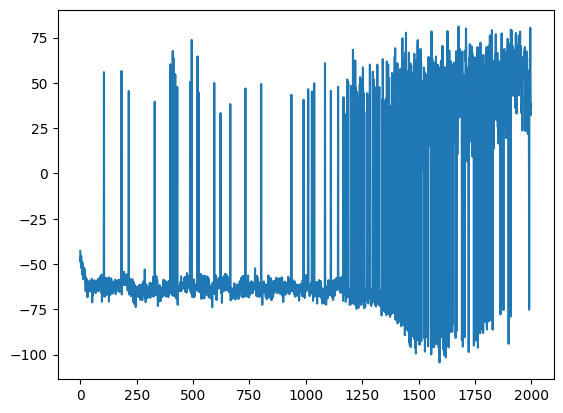

In [90]:
%matplotlib inline

plt.plot(return_list)
plt.show()

In [91]:
%matplotlib qt5

def test_agent(agent, env_name):
    env = gym.make(env_name, render_mode="human")

    state, info = env.reset()

    print(f"Starting observation: {state}")

    episode_over = False
    total_reward = 0
    action_list = []

    while not episode_over:
        action = agent.take_action(state, eval = True)
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        episode_over = terminated or truncated
        # print(f"{action=}")
        action_list.append(action)

    print(f"Episode finished! Total reward: {total_reward}")
    env.close()
    return action_list
    

action_list = test_agent(agent, env_name)

Starting observation: [-0.507214  0.      ]
Episode finished! Total reward: 34.4326500739091


In [62]:
plt.hist(action_list, bins=30, density=True, alpha=0.7)
plt.show()